# Lexical Analyzer

In [105]:

from __future__ import annotations
from typing import Dict, Optional
from collections import deque, defaultdict
import json

import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import to_agraph
from PIL import Image


## Regex Parser 

- operator precedence:
    1. paranthesis: ()
    2. counters:    * + ?
    3. concetation: ab
    4. disjuntion:  a | b
    5. range        [] 
    
- use _ as concate operator as '.' mean anything

In [89]:
def __tokenize_regex(regex:str) -> list[tuple[str, str]]:
    tokens = []
    i = 0
    while i < len(regex):
        if regex[i] == "-":                         #"a-z"
            tokens[-1] = (regex[i-1:i+2], "var")    # remove a & add a-z
            i += 2                                  # skip z                    
        elif regex[i] in "()[]*+?_|":
            tokens.append((regex[i], "op"))
            i += 1
        else:
            tokens.append((regex[i], "var"))
            i += 1
    return tokens

def __replace_range(tokens)  -> list[tuple[str, str]]:
    new_tokens = []
    inside_range = False
    var_before_me = False
    
    for val, type in tokens:
        if val == "[": inside_range = True
        elif val == "]": inside_range = False
        elif inside_range and var_before_me: new_tokens.append(("|", "op"))
    
        new_tokens.append((val, type))
        var_before_me = type == "var"
    return new_tokens

def __insert_concate(tokens: list[tuple[str, str]]) -> list[tuple[str, str]]:
    new_tokens = []
    for i in range(len(tokens)-1):
        new_tokens.append(tokens[i])
        curr_token, curr_type = tokens[i]
        nxt_token, nxt_type = tokens[i+1]

        if ((curr_type == "var" or curr_token in ")]*+?") 
            and (nxt_type == "var" or nxt_token in "([")) :
            new_tokens.append(("_", "op"))
    
    new_tokens.append(tokens[-1])
    return new_tokens



def infix_to_postfix(regex: str) -> str:
    operators = {"*": -1, "+": -2, "?": -3, "_": -4, "|": -5, "(": -100, "[": -100}
    
    tokens = __replace_range(__tokenize_regex(regex))
    tokens = __insert_concate(tokens)
    
    postfix_expr = []
    op_stack = []
    
    def pop_op_stack():
        postfix_expr.append(op_stack[-1])
        op_stack.pop()
        
    for (token, type) in tokens:
        if token in '([':
            op_stack.append(token)
            
        elif token in ')]':
            while op_stack[-1] not in '([': pop_op_stack()
            op_stack.pop()
            
        elif type == "op":
            while len(op_stack) != 0 and operators[token] <= operators[op_stack[-1]]:  pop_op_stack()
            op_stack.append(token)
            
        else:
            postfix_expr.append(token)
            
    while len(op_stack) != 0: pop_op_stack()
        
    return postfix_expr


In [90]:
def test_processor():
    test_cases = [
        ("ab", ["a", "b", "_"]),
        ("a|b", ["a", "b", "|"]),
        ("(a|b)*", ["a", "b", "|", "*"]),
        ("a.b", ["a", ".", "_", "b", "_"]), 
        ("[a-z]?e", ["a-z", "?", "e", "_"]),
        ("a(b|c)*", ["a", "b", "c", "|", "*", "_"]),
    ]
    
    for infix, expected in test_cases:
        result = infix_to_postfix(infix)
        print(f"Input: {infix:<10} Output: {result}")
        assert result == expected, f"Failed for {infix}. Expected {expected}, got {result}"
    print("All tests passed!")
   
test_processor() 

Input: ab         Output: ['a', 'b', '_']
Input: a|b        Output: ['a', 'b', '|']
Input: (a|b)*     Output: ['a', 'b', '|', '*']
Input: a.b        Output: ['a', '.', '_', 'b', '_']
Input: [a-z]?e    Output: ['a-z', '?', 'e', '_']
Input: a(b|c)*    Output: ['a', 'b', 'c', '|', '*', '_']
All tests passed!


## NFA Generator

In [91]:
class State:
    def __init__(self, state_num: int):
        self.transitions : Dict[str, list[State]] = defaultdict(list)
        self.state_name = f"S{state_num}"
    
    def add_transition(self, next_state: State, edge: str = "ε") -> None:
        self.transitions[edge].append(next_state)


In [95]:
class NFA:
    def __init__(self, start_counting_from = 0, initial_state = None, terminating_state = None):
        self.state_counter = start_counting_from
        self.initial_state: Optional[State] = initial_state
        self.terminating_state: Optional[State] = terminating_state
    
    def build_nfa_from_postfix(self, regex: list[str]):
        subsets = []
        op_compilers = {
            "*": self.compile_zero_or_more,
            "+": self.compile_one_or_more,
            "?": self.compile_zero_or_one,
            "_": self.compile_concat,
            "|": self.compile_or,
        }
    
        postfix = infix_to_postfix(regex)
        for token in postfix:
            if token in "|_": 
                subset = op_compilers[token](subsets[-2], subsets[-1])
                subsets.pop()
                subsets.pop()
                subsets.append(subset)
            elif token in "*+?": 
                subset = op_compilers[token](subsets[-1])
                subsets.pop()
                subsets.append(subset)
            else:
                subsets.append(self.compile_variable(token))
                
        return subsets[0]
        
    def create_state(self) -> State:
        """create a new state with auto-incremented counter"""
        state = State(self.state_counter)
        self.state_counter += 1
        return state
    
    def compile_variable(self, variable: str) -> NFA:
        """  S0 -- variable/character --> Se  """
        initial_state = self.create_state()
        terminating_state = self.create_state()
        
        initial_state.add_transition(terminating_state, variable)
        
        return NFA(
            initial_state=initial_state,
            terminating_state=terminating_state
        )
        
    def compile_zero_or_more(self, state: NFA) -> NFA:
        """  
            S0 -- state --> Se
             ^-------   
             -------------- ^  
        """
        initial_state = self.create_state()
        terminating_state = self.create_state()
        
        initial_state.add_transition(state.initial_state)
        initial_state.add_transition(terminating_state)
        
        state.terminating_state.add_transition(initial_state)
        state.terminating_state.add_transition(terminating_state)
        
        return NFA(
            initial_state=initial_state,
            terminating_state=terminating_state
        )
        
    def compile_one_or_more(self, state: NFA):
        """  
            S0 -- state --> Se
             ^-------   
        """
        initial_state = self.create_state()
        terminating_state = self.create_state()
        
        initial_state.add_transition(state.initial_state)
        
        state.terminating_state.add_transition(initial_state)
        state.terminating_state.add_transition(terminating_state)
        
        return NFA(
            initial_state=initial_state,
            terminating_state=terminating_state
        )
    
    def compile_zero_or_one(self, state: NFA):
        """  
            S0 -- state --> Se
            -------------- ^ 
        """
        initial_state = self.create_state()
        terminating_state = self.create_state()

        
        initial_state.add_transition(state.initial_state)
        initial_state.add_transition(terminating_state)
        state.terminating_state.add_transition(terminating_state)
        
        return NFA(
            initial_state=initial_state,
            terminating_state=terminating_state
        )
        
        
    def compile_concat(self, state1: NFA, state2: NFA) -> NFA:
        """  
            s1 ---> s2
        """
        output = state1
        
        output.terminating_state.add_transition(state2.initial_state)
        
        output.terminating_state = state2.terminating_state
        
        return output
    
    def compile_or(self, state1: NFA, state2: NFA):
        """  
                  state1
            S0 --/     \-->se
                 \     /
                  state2
        """
        initial_state = self.create_state()
        terminating_state = self.create_state()
        
        initial_state.add_transition(state1.initial_state)
        initial_state.add_transition(state2.initial_state)
        
        state1.terminating_state.add_transition(terminating_state)
        state2.terminating_state.add_transition(terminating_state)
        
        return NFA(
            initial_state=initial_state,
            terminating_state=terminating_state
        )
    
    def to_dict(self) -> dict:
        """Convert the NFA to a dictionary in the specified JSON format"""
        result = {  "startingState": self.initial_state.state_name }
        
        # BFS to collect all states
        visited, queue = set(), deque([self.initial_state])
        
        while queue:
            current_state = queue.popleft()
            
            if current_state.state_name in visited:  continue
            visited.add(current_state.state_name)
            
            state_entry = {"isTerminatingState": current_state == self.terminating_state}
            for edge, next_states in current_state.transitions.items():
                state_entry[edge] = [next_state.state_name for next_state in next_states]
                for next_state in next_states:
                    if next_state.state_name not in visited:
                        queue.append(next_state)
            
            result[current_state.state_name] = state_entry
        
        return result
    
    def to_json(self) -> str:
        return json.dumps(self.to_dict(), indent=2)
   

<>:121: SyntaxWarning: invalid escape sequence '\-'
<>:121: SyntaxWarning: invalid escape sequence '\-'
/tmp/ipykernel_71565/986788713.py:121: SyntaxWarning: invalid escape sequence '\-'
  """


In [96]:
def plot_nfa(nfa: NFA):
    data = nfa.to_dict()
    G = nx.DiGraph()

    # Add states (nodes)
    for state, transitions in data.items():
        if state == "startingState": continue
        G.add_node(state, shape="doublecircle" if transitions["isTerminatingState"] else "circle")
        
        for symbol, next_states in transitions.items():
            if symbol == "isTerminatingState": continue
            for next_state in next_states: 
                G.add_edge(state, next_state, label=symbol)
    A = to_agraph(G)
    # A.node_attr.update(style='filled', fillcolor='thistle', fontname='Helvetica', fontsize=14)
    # A.edge_attr.update(fontname='Helvetica', fontsize=12)
    
    # Set the initial state
    A.add_node("st", shape="none", label="")
    A.add_edge("st", data["startingState"])
    
    A.graph_attr.update(rankdir='LR')
    # Render and display
    A.layout(prog='dot')
    A.draw("nfa.png")
    
    return Image.open("nfa.png")

In [113]:
def test_nfa():
    testcases = [
        "a",
        "ab",
        "abc",
        "abc?",
        "a|b?",
    ]
    for regex in testcases:
        result_nfa = NFA().build_nfa_from_postfix(regex)
        print(regex)
        print(result_nfa.to_dict())
        img = plot_nfa(result_nfa)
        display(img)


a
{'startingState': 'S0', 'S0': {'isTerminatingState': False, 'a': ['S1']}, 'S1': {'isTerminatingState': True}}


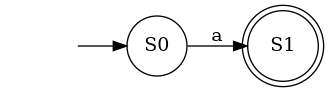

ab
{'startingState': 'S0', 'S0': {'isTerminatingState': False, 'a': ['S1']}, 'S1': {'isTerminatingState': False, 'ε': ['S2']}, 'S2': {'isTerminatingState': False, 'b': ['S3']}, 'S3': {'isTerminatingState': True}}


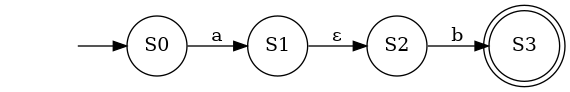

abc
{'startingState': 'S0', 'S0': {'isTerminatingState': False, 'a': ['S1']}, 'S1': {'isTerminatingState': False, 'ε': ['S2']}, 'S2': {'isTerminatingState': False, 'b': ['S3']}, 'S3': {'isTerminatingState': False, 'ε': ['S4']}, 'S4': {'isTerminatingState': False, 'c': ['S5']}, 'S5': {'isTerminatingState': True}}


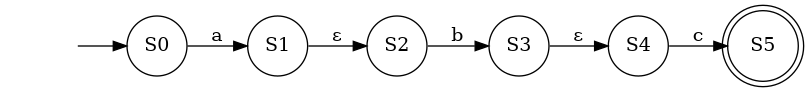

abc?
{'startingState': 'S0', 'S0': {'isTerminatingState': False, 'a': ['S1']}, 'S1': {'isTerminatingState': False, 'ε': ['S2']}, 'S2': {'isTerminatingState': False, 'b': ['S3']}, 'S3': {'isTerminatingState': False, 'ε': ['S6']}, 'S6': {'isTerminatingState': False, 'ε': ['S4', 'S7']}, 'S4': {'isTerminatingState': False, 'c': ['S5']}, 'S7': {'isTerminatingState': True}, 'S5': {'isTerminatingState': False, 'ε': ['S7']}}


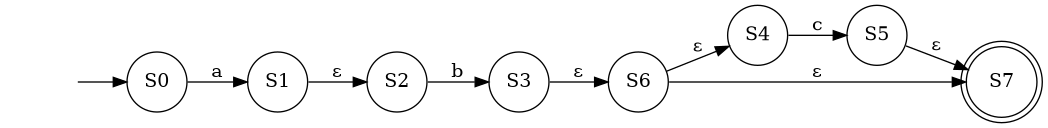

a|b?
{'startingState': 'S6', 'S6': {'isTerminatingState': False, 'ε': ['S0', 'S4']}, 'S0': {'isTerminatingState': False, 'a': ['S1']}, 'S4': {'isTerminatingState': False, 'ε': ['S2', 'S5']}, 'S1': {'isTerminatingState': False, 'ε': ['S7']}, 'S2': {'isTerminatingState': False, 'b': ['S3']}, 'S5': {'isTerminatingState': False, 'ε': ['S7']}, 'S7': {'isTerminatingState': True}, 'S3': {'isTerminatingState': False, 'ε': ['S5']}}


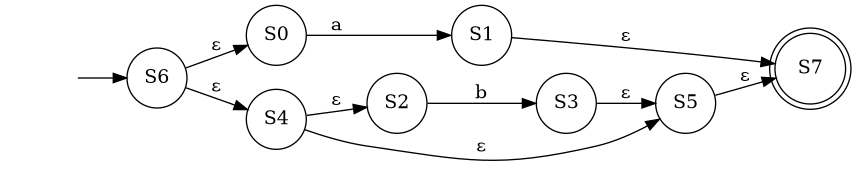

In [114]:
test_nfa()